In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import os
import glob

!ls $results_dir/bio_mira

In [9]:
results_dir = 'data/frankencell/results_summary/'

In [10]:
def read_results(path):
    trials = []
    for method in glob.glob(path):
        for filename in glob.glob(
            os.path.join(method, '*-*-*-*.tsv')
        ):
            method = os.path.basename(method).split('_')[-1]
            fields = list(map(float, os.path.basename(filename)[:-3].split('-')))

            trial_attrs = dict(zip(['method','NK_ratio','B_ratio','k','seed'],
                                   [method, *fields]))

            trial_results = pd.read_csv(filename, sep = '\t', header=None)
            trial_results.columns = ['metric','score']

            trial_attrs.update(
                trial_results.set_index('metric')['score'].to_dict()
            )

            trials.append(trial_attrs)

    trials = pd.DataFrame(trials)
    trials['trial_signature'] = list(zip(trials.NK_ratio, trials.B_ratio))
    
    trials['id'] = list(zip(trials.NK_ratio, trials.B_ratio, trials.k, trials.seed, trials.method))

    return trials.set_index('id')

bio_scores = read_results('data/frankencell/results_summary/bio_*')
batch_scores = read_results('data/frankencell/results_summary/batch_*')

In [11]:
trial_order = []
for r in [1/2, 1/6, 1/18, 0.]:
    trial_order.append((0.5,r))
for r2 in [1/6, 1/18, 0.]:
    trial_order.append((r2, r))

In [12]:
bio_scores = bio_scores.join(batch_scores['ilisi_score'])

In [13]:
trials = bio_scores
trials = trials[(trials.k <= 0.15) & ~(trials.method == 'mira-notune')]

In [14]:
#trials = trials[trials.seed < 50]

In [15]:
metrics = ['correlation','edge_flip','F1_branches']
id_cols = ['method','NK_ratio','B_ratio','k','seed']

In [16]:
from sklearn.preprocessing import StandardScaler
from scipy.special import expit

In [17]:
compound_metrics = ['edge_flip', 'correlation', 'F1_branches','ilisi_score']

In [18]:
from scipy.stats import gmean

trials['overall_score'] = gmean(
    expit(
        StandardScaler().fit(
            trials[compound_metrics].values,
        ).transform(
            trials[compound_metrics].values,
        )
    ),axis = 1)
#)
trials['method_class'] = trials.method.str.split('-').str.get(0)

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
trials = trials.groupby(['seed']).apply(lambda x : x.sort_values('overall_score', ascending = False))\
    .groupby(['method_class','trial_signature','k']).head(1)

In [20]:
trials.shape

(83, 18)

In [21]:
trials['trial_sig_id'] = trials.trial_signature.map(dict(zip(trial_order, range(len(trial_order)))))

In [22]:
trials.method.unique()

array(['mira', 'scvi-notune-4', 'scvi-notune-5', 'harmony',
       'scvi-notune-3', 'scvi-notune-6'], dtype=object)

In [23]:
b = sns.diverging_palette(40, 200, s=80, l = 55,n=6)
#b = sns.color_palette('RdBu')
edge_palette = {
      '1' : 'lightgrey',#sns.color_palette('Purples')[1], 
      '3' : b[2], 
      '2' : sns.color_palette('RdBu')[-3],
      'Mono' : b[0],
      'B cell' : sns.color_palette('RdBu')[-1],
      'NK' : sns.color_palette('RdBu')[-2],
      'pDC' : b[1], 
}

for k, v in edge_palette.items():
    print(k, cm.to_hex(v))

In [24]:
method_palete = {
    'mira' : 'tomato',
    'scvi' : 'black',
    'harmony' : '#eeeeee',
    'scanorama' : 'green',
}

#b = sns.diverging_palette(145, 300, s=60,n=6)
b = sns.color_palette('BuPu')

edge_palette = {
      '1' : sns.color_palette('Purples')[1], 
      '2' : b[2], 
      '3' : b[-3],
      'B cell' : b[0],
      'Mono' : b[-1],
      'pDC' : b[-2],
      'NK' : b[1], 
}

In [25]:
trials = trials.set_index(np.arange(trials.shape[0]))

In [141]:
NK_ratio, B_ratio = list(map(list, list(zip(*trial_order))))

def plot_composition(ax, ratio):
    
    ax.fill_between(
        np.arange(len(ratio)),
        1 - np.array(ratio),
        color = edge_palette['NK'],
    )
    
    ax.plot(
        np.arange(len(ratio)),
        1 - np.array(ratio),
        color = 'black',
        linewidth = 0.5,
    )
    
    ax.fill_between(
        np.arange(len(ratio)),
        np.ones(len(ratio)),
        1 - np.array(ratio),
        color = edge_palette['B cell'],
    )
    
    ax.plot(
        np.arange(len(ratio)),
        np.ones(len(ratio)),
        color = 'black',
        linewidth = 0.5,
    )

def plot_ratios(ax):
    
    plot_composition(ax[1], list(map(lambda x : 1 - x, NK_ratio)))
    plot_composition(ax[0], B_ratio)

    #ax[0].scatter(
    #    np.arange(len(NK_ratio)),
    #    NK_ratio,
    #    c = '#f09c7b',
    #    s = 10,
    #)


    '''ax[1].plot(
        np.arange(len(NK_ratio)),
        B_ratio,
        '-',
        c = '#c13639',
        linewidth = 2,
    )

    ax[1].scatter(
        np.arange(len(NK_ratio)),
        B_ratio,
        c = '#c13639',
        s = 10,
    )'''

    ax[1].set_xticks(np.arange(len(NK_ratio)))
    ax[1].set_xticklabels([])

    ax[0].set(yticks = [0.,0.5,1.])
    ax[0].set_yticklabels([])
    
    ax[1].set(yticks = [0.,0.5,1.])
    ax[1].set_yticklabels([])
    
    sns.despine()
    plt.tight_layout()
    
    return ax

def plot_trial_scores(trials, ax, score = 'F1_branches'):    

    sns.stripplot(
        ax = ax,
        data = trials,
        x = 'trial_sig_id',
        y = score,
        hue = 'method_class',
        size = 8,
        palette=method_palete.values(),
        hue_order = method_palete.keys(),
        edgecolor = 'black',
        linewidth = 0.5,   
        #legend=False
    )
    ax.set(xlabel = None, yticks = [0.3, 0.5, 0.7, 0.9, 1.], ylabel = None)
    ax.set_yticklabels([])

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


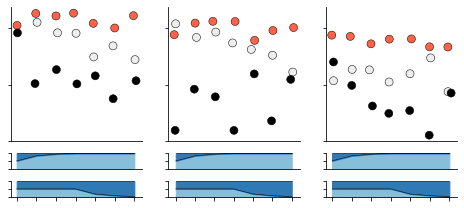

In [28]:
fig, ax = plt.subplots(3,3,figsize=(8,3.5), sharex='col', sharey='row',
                      gridspec_kw = dict(height_ratios = [4,0.5,0.5], hspace = 0.2, wspace = 0.2),)

for i, k in enumerate([0., 0.05, 0.1]):
    ax_ = ax[:,i]
    plot_trial_scores(trials[trials.k == k], ax_[0])
    ax_[0].xaxis.set_ticks_position('none')
    plot_ratios(ax_[1:])
    ax_[0].legend([],[], frameon=False)
    ax_[1].xaxis.set_ticks_position('none')
    
plt.savefig('figure2/F1_branches_results.svg')

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



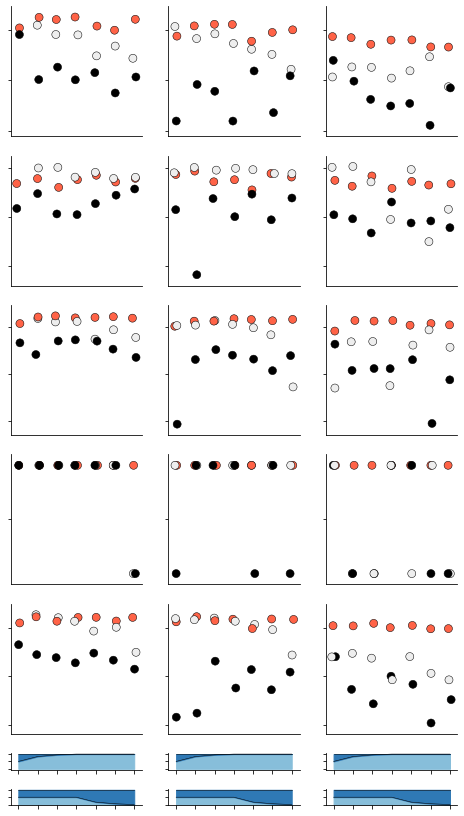

In [139]:
fig, ax = plt.subplots(7,3,figsize=(8,3.5 + 4*2.8), sharex='col', sharey='row',
                      gridspec_kw = dict(height_ratios = [4,4,4,4,4,0.5,0.5], hspace = 0.2, wspace = 0.2),)

for i, k in enumerate([0., 0.05, 0.1]):
    for j, score in enumerate(['F1_branches','ilisi_score','correlation','edge_flip','overall_score']):
        ax_ = ax[j,i]
        plot_trial_scores(trials[trials.k == k], ax_, score = score)
        
        ax_.xaxis.set_ticks_position('none')
        ax_.legend([],[], frameon=False)
        ax_.xaxis.set_ticks_position('none')
        ax_.set_ymargin(0.1)
    plot_ratios(ax[-2:,i])

plt.savefig('sup3/all_frankencell_scores.svg')

In [140]:
trials.to_csv('tables/frankencell_results.tsv', sep = '\t')

flat_trials = trials.melt(id_vars=['method_class','trial_signature','NK_ratio','B_ratio','seed','k'], value_name='score', var_name='metric')

sns.catplot(
    data = flat_trials[(flat_trials.k <= 0.15)],# & flat_trials.method.isin(['mira','mira-notune','harmony','scvi-notune-4'])],
    col='k',
    x = 'trial_signature',
    order=trial_order,
    y = 'score',
    hue = 'method_class',
    s = 10,
    row = 'metric',
    sharex='col',
    sharey='row',
    height=3,
    aspect=1.,
    facet_kws= dict(gridspec_kws = dict(wspace = 0.)),
)
plt.tight_layout()

sns.catplot(
    data = flat_trials[(flat_trials.k <= 0.1) & flat_trials.method.isin(['mira','harmony','scvi-notune-4'])],
    col='trial_signature',
    col_order=trial_order,
    x = 'k',
    y = 'score',
    hue = 'method',
    s = 20,
    row = 'metric',
    sharex='col',
    sharey='row',
)

# Umaps

In [1]:
import sys
sys.path.insert(0, '/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages')
import disentangler as dt
from disentangler.dependencies import *
import disentangler.frankencell.config as dtconfig
import seaborn as sns

#import scib
import anndata
import scanpy as sc
import pandas as pd
import frankencell

In [2]:
b = sns.diverging_palette(40, 200, s=80, l = 55,n=6)
edge_palette = {
      '1' : 'lightgrey',#sns.color_palette('Purples')[1], 
      '3' : b[2], 
      '2' : sns.color_palette('RdBu')[-3],
      'Mono' : b[0],
      'B cell' : sns.color_palette('RdBu')[-1],
      'NK' : sns.color_palette('RdBu')[-2],
      'pDC' : b[1], 
}

In [3]:
edge_kwargs = dict(
    palette=edge_palette.values(),
    hue_order = edge_palette.keys(),
    legend=False, edgecolor = None,
    s = 50,
)

batch_palette = {
      '1' : 'lightgrey',
      '0' : 'black',
}

batch_kwargs = dict(
    palette=batch_palette.values(),
    hue_order = batch_palette.keys(),
    legend=False, 
    edgecolor = None,
    s = 50,
)

def get_sigil(data, ax):
    
    batch_mask = data.obs.batch == '1'
    
    w = data.obs[['mix_weight_0', 'mix_weight_1', 'mix_weight_2', 'mix_weight_3',
           'mix_weight_4', 'mix_weight_5', 'mix_weight_6']].values.copy()

    weights = np.vstack([
        w[:,0], w[:,1], w[:, [5,6]].sum(-1), w[:,2], w[:,[3,4]].sum(-1),
    ]).T

    y,x=frankencell.scaffold.cartesian_projection(weights)

    y = -np.clip(y, -0.45, 0.85)
    x_jitter = np.random.rand(len(x)) * 0.025
    y_jitter = np.random.rand(len(x)) * 0.025
    
    batch1_kwargs = dict(
        x= x[batch_mask] + x_jitter[batch_mask], 
        y = y[batch_mask] + y_jitter[batch_mask],
    )
    
    batch2_kwargs = dict(
        x = x[~batch_mask] + 0.15 + x_jitter[~batch_mask], 
        y = y[~batch_mask] - 0. + y_jitter[~batch_mask],
    )

    sns.scatterplot(
        ax = ax[0], 
        **batch1_kwargs,
        hue = data[batch_mask].obs.edge.values,
        **edge_kwargs,
    )
    
    sns.scatterplot(
        ax = ax[0], 
        **batch2_kwargs,
        hue = data[~batch_mask].obs.edge.values,
        **edge_kwargs,
    )
    
    sns.scatterplot(
        ax = ax[1], 
        **batch1_kwargs,
        hue = data[batch_mask].obs.batch.values,
        **batch_kwargs,
    )
    
    sns.scatterplot(
        ax = ax[1], 
        **batch2_kwargs,
        hue = data[~batch_mask].obs.batch.values,
        **batch_kwargs,
    )
    
    ax[0].axis('off')
    ax[1].axis('off')
    
    return ax

In [4]:
import matplotlib.colors as cm

In [5]:
for k, v in edge_palette.items():
    print(k, cm.to_hex(v))

1 #d3d3d3
3 #e7d8cc
2 #dbeaf2
Mono #b57539
B cell #2f79b5
NK #87beda
pDC #cea782


# Intro PCA

In [24]:
def process_counts(testdata):
    
    sc.pp.filter_genes(testdata, min_cells = 15)
    testdata.raw = testdata

    sc.pp.normalize_total(testdata, target_sum=1e4)
    sc.pp.log1p(testdata)
    sc.pp.highly_variable_genes(testdata)

    testdata.layers['counts'] = testdata.raw.to_adata().X.copy()

    sc.pp.highly_variable_genes(testdata, min_disp=0.5)

    sc.tl.pca(testdata)

    sc.pp.neighbors(testdata, use_rep='X_pca', n_pcs=5)
    sc.tl.umap(testdata, min_dist=0.1, negative_sample_rate=5)
    
    return testdata

In [26]:
def read_test(path):

    testdata = frankencell.read_dynframe(path)

    return process_counts(testdata)

In [27]:
!mkdir -p figure2

/liulab/alynch/projects/multiomics/DisentanglerReproduction/lib/frankencell-python/frankencell/utils.py:61: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'feature_type' as categorical


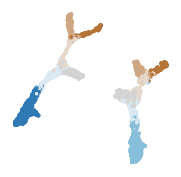

In [34]:
dataset = frankencell.read_dynframe('data/frankencell/test/0.0-0.0-0.0-24.h5')

dataset = process_counts(dataset)

fig, ax = plt.subplots(1,1,figsize=(3,3))
celltype_umap(dataset, ax)

plt.savefig('figure2/confounded_plan_example.png', dpi = 300, bbox_inches = 'tight')

/liulab/alynch/projects/multiomics/DisentanglerReproduction/lib/frankencell-python/frankencell/utils.py:61: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'feature_type' as categorical


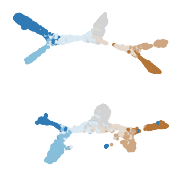

In [35]:
dataset = frankencell.read_dynframe('data/frankencell/test/0.5-0.5-0.0-0.h5')

dataset = process_counts(dataset)

fig, ax = plt.subplots(1,1,figsize=(3,3))
celltype_umap(dataset, ax)

plt.savefig('figure2/easiest_plan_example.png', dpi = 300, bbox_inches = 'tight')

# Dimred figures

In [49]:
def read_dimred_file(path):
    
    dimred = pd.read_csv(path, sep= '\t')\
        .set_index('cell_id')

    X = dimred.iloc[:,dimred.columns.str.startswith('dimred')].values

    data = anndata.AnnData(
        obs = dimred,
        obsm = {'X_dimred' : X}
    )

    sc.pp.neighbors(data, use_rep='X_dimred', metric = 'manhattan',
                   n_neighbors = 25)
    sc.tl.umap(data, min_dist=0.1)

    data.obs['batch'] =data.obs['batch'].astype(str)
    
    return data

In [134]:
print_trials = trials[trials.k == 0.0]

In [135]:
dimreds = {}
for k in [0.0]:
    for NK, B in [(0.5, 0.), (0.0,0.0),(0.5,0.5)]:
        for method in ['mira','harmony','scvi']:
            info = print_trials[print_trials.trial_signature == (NK,B)].set_index('method_class').loc[method].to_dict()
            info['seed'] = int(info['seed'])
            path = 'data/frankencell/dimred/{method}/{NK_ratio}-{B_ratio}-{k}-{seed}.tsv'.format(**info)
            print(path)
            dimreds[(method, (NK,B))] = read_dimred_file(path)

data/frankencell/dimred/mira/0.5-0.0-0.0-12.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



data/frankencell/dimred/harmony/0.5-0.0-0.0-12.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



data/frankencell/dimred/scvi-notune-4/0.5-0.0-0.0-12.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



data/frankencell/dimred/mira/0.0-0.0-0.0-24.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



data/frankencell/dimred/harmony/0.0-0.0-0.0-24.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



data/frankencell/dimred/scvi-notune-3/0.0-0.0-0.0-24.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



data/frankencell/dimred/mira/0.5-0.5-0.0-0.tsv


/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



KeyError: 'harmony'

In [ ]:
dimreds[('harmony',(0.5,0.5))] = dimreds[('harmony',(0.5,0.5))][dimreds[('harmony',(0.5,0.5))].obsm['X_umap'][:,1] < 5]

In [52]:
!mkdir -p figure2/umaps

In [53]:
import os

In [54]:
def rot(t):
    return np.array([[np.cos(t), -np.sin(t)],[np.sin(t), np.cos(t)]])

In [55]:
from collections import defaultdict

In [131]:
def celltype_umap(data, ax, rot, invert_x = False, invert_y = False, size = 10):
    
    data.obsm['X_translated'] = np.dot(data.obsm['X_umap'], rot)
    
    sc.pl.embedding(data, color = 'edge', frameon=False,
              na_color='lightgrey', show=False,
              palette=edge_palette, basis = 'X_translated',
               size=size, legend_loc= None,
               title = '', ax = ax
            )
    
    if invert_x:
        ax.axes.invert_xaxis()
        
    if invert_y:
        ax.axes.invert_yaxis()
        
    return ax
    
def batch_umap(data, ax, rot,invert_x = False, invert_y = False, size = 10):
    
    data.obs['batch'] = data.obs['batch'].astype(str)
    
    data.obsm['X_translated'] = np.dot(data.obsm['X_umap'] + size/30 * data.obs.batch.astype(int)[:,None], rot) 
    
    if invert_x:
        data.obsm['X_translated'] = data.obsm['X_translated']*np.array([[-1,1]])
        
    sc.pl.embedding(data, color = 'batch', frameon=False,
              na_color='lightgrey', show=False,
              palette=batch_palette, basis = 'X_translated',
               size=size, legend_loc= None, 
               title = '', ax = ax, add_outline = True,
              )
    
    #if invert_x:
    #    ax.axes.invert_xaxis()
        
    if invert_y:
        ax.axes.invert_yaxis()
        
    return ax

In [132]:
rotation = defaultdict(lambda : 0., {
    ('mira', (0.5,0.5)) : -3*np.pi/4,
    ('harmony', (0.5,0.)) : np.pi,
    ('mira', (0.5,0.)) : -3*np.pi/4,
})

invert = defaultdict(lambda : False, {
    ('mira', (0.5,0.5)) : True,
    ('mira', (0.5,0.)) : True,
    ('harmony', (0.5,0.)) : True,
    ('harmony', (0.,0.)) : True,
})

invert_y = defaultdict(lambda : False, {
    ('harmony', (0.5,0.5)) : True,
})

... storing 'edge' as categorical
... storing 'batch' as categorical
/liulab/alynch/projects/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

... storing 'batch' as categorical
... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'batch' as categorical
... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'batch' as categorical
... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'batch' as categorical
... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'batch' as categorical
... storing 'edge' as categorical
... storing 'batch' as categorical
... storing 'batch' as categorical


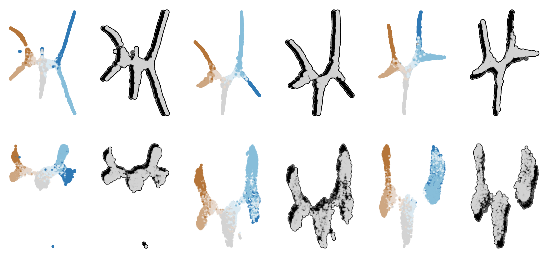

In [133]:
fig, ax = plt.subplots(2,6,figsize=(8,4))
a = np.ravel(ax)
i = 0
for method in ['mira','harmony']:
    for sig in [(0.5,0.5), (0.5, 0.), (0.,0.)]:
        
        #folder = os.path.join('figure2','umaps',method)
        #if not os.path.exists(folder):
        #    os.mkdir(folder)
        d = dimreds[(method, sig)]
        #plt.savefig(
        #    os.path.join(folder, '{}-{}-{}.png'.format(
        #        *sig, 'batch'
        #    )), bbox_inches = 'tight', dpi = 300,
        #)
        
        ax = celltype_umap(d, a[i],rot(rotation[(method, sig)]), invert_x=invert[(method,sig)],
                           invert_y=invert_y[(method,sig)], size = 15 + 15 * (method == 'mira'))
        i+=1
        ax = batch_umap(d, a[i], rot(rotation[(method, sig)]), invert_x=invert[(method,sig)],
                       invert_y=invert_y[(method,sig)], size = 15 + 15 * (method == 'mira'))
        i+=1
        #plt.savefig(
        #    os.path.join(folder, '{}-{}-{}.png'.format(
        #        *sig, 'celltype'
        #    )), bbox_inches = 'tight', dpi = 300,
        #)

        plt.tight_layout()
        
plt.savefig('figure2/umap_squares.png', dpi = 300, bbox_inches = 'tight')

In [128]:
!realpath figure2/umap_squares.png

/liulab/alynch/projects/multiomics/DisentanglerReproduction/figure2/umap_squares.png
